In [8]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src')

import pandas as pd
pd.set_option('display.max_rows', 100)

import cudf
import xgboost
import lightgbm
from pathlib import Path
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    context="talk", style="darkgrid", palette="dark", font="sans-serif"
)

from sales_project.utils import get_bins
from sales_project.plotters import linear_plot
from sales_project.evaluations import evaluate
from sales_project.utils import save_model, load_model
from sales_project.utils import save_predictions, read_yaml, save_yaml
from sales_project.tuners import run_optuna, time_series_objective

In [2]:
target = 'item_cnt_month'
timestamp_col = 'date_block_num'

df_test = pd.read_parquet("../data/artifacts/df3.parquet").query(f"{timestamp_col} == 33")
df_test[target] = df_test[target].clip(0, 20)


features = list(df_test.columns)
features.remove(target)
features.remove(timestamp_col)
features.remove('shop_id')
features.remove('item_id')
#df = df.query('date_block_num <= 32')

In [3]:
shops = pd.read_csv('../data/raw/shops.csv')[['shop_id', 'shop_name']]
items = pd.read_csv('../data/raw/items.csv')[['item_id', 'item_name', 'item_category_id']]
item_categories = pd.read_csv('../data/raw/item_categories.csv')[['item_category_name', 'item_category_id']]

df_test = df_test.merge(shops, on='shop_id', how='left')
df_test = df_test.merge(items, on='item_id', how='left')
df_test = df_test.merge(item_categories, on='item_category_id', how='left')

In [4]:
model = load_model('test_XGBRegressor_2024-08-15_16:44:26.pkl')
df_test['pred'] = model.predict(df_test[features]).clip(0, 20)

In [5]:
features2 = [
    'shop_id', 
    'item_id', 
    'item_category_id', 
    'shop_name', 
    'item_name', 
    'item_category_name',
    'item_cnt_month',
    'pred',
    'residual',
    'abs_residual'
]

In [6]:
df_test['residual'] = (df_test['pred'] - df_test[target])
df_test['abs_residual'] = df_test['residual'].abs()

df_test = df_test.sort_values('abs_residual', ascending=False)

In [7]:
df_test[features2].head(10)

,shop_id,item_id,item_category_id,shop_name,item_name,item_category_name,item_cnt_month,pred,residual,abs_residual
100195,9,8550,42,Выездная Торговля,Артбук Мир игры The Last Of Us,"Книги - Артбуки, энциклопедии",20.0,0.000000,-20.000000,20.000000
97335,39,16629,37,"РостовНаДону ТРК ""Мегацентр Горизонт""",ОСТАВЛЕННЫЕ (BD),Кино - Blu-Ray,20.0,0.027349,-19.972651,19.972651
135746,39,17270,37,"РостовНаДону ТРК ""Мегацентр Горизонт""",ПОСЛЕДНИЙ РУБЕЖ (BD),Кино - Blu-Ray,20.0,0.027886,-19.972115,19.972115
6382,20,13308,47,"Москва ""Распродажа""",Комикс Сорвиголова Том 1,"Книги - Комиксы, манга",20.0,0.048273,-19.951727,19.951727
6404,20,13233,47,"Москва ""Распродажа""",Комикс Бэтмен Год первый,"Книги - Комиксы, манга",20.0,0.120166,-19.879835,19.879835
6642,20,14956,47,"Москва ""Распродажа""",Манга Без игры жизни нет Том 1,"Книги - Комиксы, манга",20.0,0.144340,-19.855659,19.855659
13245,20,13331,47,"Москва ""Распродажа""",Комикс Хоукай Соколиный глаз Том 1 Быть оружием,"Книги - Комиксы, манга",20.0,0.144486,-19.855515,19.855515
6992,20,13294,47,"Москва ""Распродажа""",Комикс Росомаха Старик Логан,"Книги - Комиксы, манга",20.0,0.170469,-19.829531,19.829531
13236,20,13339,47,"Москва ""Распродажа""",Комикс Эра Альтрона Книга 1,"Книги - Комиксы, манга",20.0,0.181276,-19.818724,19.818724
5443,9,13218,47,Выездная Торговля,Комикс Mortal Kombat X Том 1 Кровавые узы,"Книги - Комиксы, манга",20.0,0.195481,-19.804520,19.804520


((array([-4.52754934, -4.33638813, -4.23267207, ...,  4.23267207,
          4.33638813,  4.52754934]),
  array([-20.      , -19.97265 , -19.972115, ...,  11.338237,  11.467147,
          13.146233], dtype=float32)),
 (0.5163475897383288, 0.02430957183241835, 0.6870968175634143))

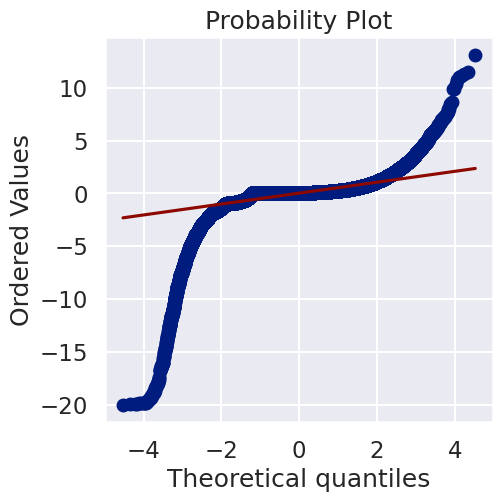

In [9]:
plt.figure(figsize=(5, 5))
stats.probplot(df_test.query('abs_residual >= 0')['residual'], dist="norm", plot=plt)

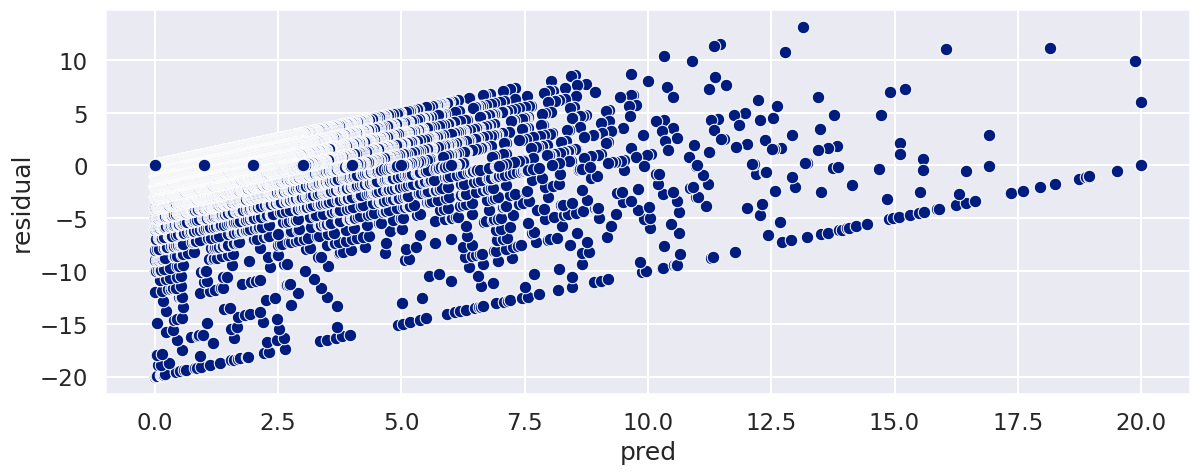

In [10]:
linear_plot(df_test, 'pred', 'residual', '', scatter=True, linear=False)

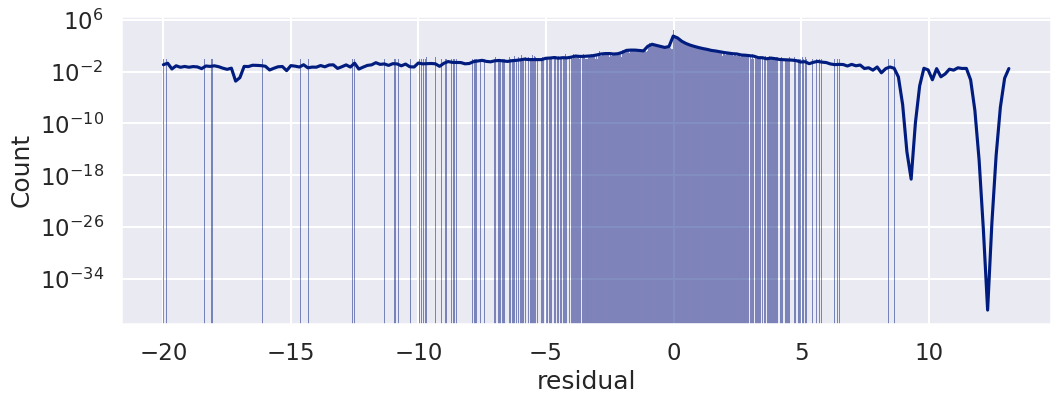

In [11]:
plt.figure(figsize=(12, 4))
sns.histplot(df_test['residual'], kde=True)
plt.yscale('log')
plt.xlabel('residual')
plt.show()

Residuals grouping by item_category_id

In [22]:
df_cat = (
    df_test.groupby("item_category_id")
    .agg({"abs_residual": "sum", "item_category_name": "first"})
    .reset_index()
    .sort_values(by="abs_residual", ascending=False)
)
df_cat

,item_category_id,abs_residual,item_category_name
29,40,8471.785156,Кино - DVD
38,55,7811.524902,Музыка - CD локального производства
27,37,4802.037109,Кино - Blu-Ray
11,20,4247.595215,Игры - PS4
21,30,3736.951660,Игры PC - Стандартные издания
10,19,3545.665771,Игры - PS3
14,23,3249.274902,Игры - XBOX 360
35,47,2901.808105,"Книги - Комиксы, манга"
45,63,2476.483398,Подарки - Мягкие игрушки
51,72,2263.001221,Подарки - Фигурки


In [36]:
df_shop = (
    df_test.groupby(["shop_id", 'item_category_id'])
    .agg({
        "shop_name": "first", 
        "item_category_name": "first",
        "item_cnt_month": "mean", 
        "pred": "mean", 
        "abs_residual": "mean", 
    })
    .reset_index()
    .sort_values(by="abs_residual", ascending=False)
)
df_shop

,shop_id,item_category_id,shop_name,item_category_name,item_cnt_month,pred,abs_residual
871,20,42,"Москва ""Распродажа""","Книги - Артбуки, энциклопедии",9.555555,0.171269,9.384287
2338,53,79,"Уфа ТЦ ""Семья"" 2",Служебные,18.000000,10.333179,7.666821
1258,28,79,"Москва ТЦ ""МЕГА Теплый Стан"" II",Служебные,20.000000,12.896848,7.103152
391,9,42,Выездная Торговля,"Книги - Артбуки, энциклопедии",7.111111,0.166630,6.998146
178,4,79,"Волжский ТЦ ""Волга Молл""",Служебные,20.000000,13.216666,6.783334
...,...,...,...,...,...,...,...
607,15,14,"Калуга ТРЦ ""XXI век""",Игровые консоли - PSVita,0.000000,0.000000,0.000000
2107,49,14,"Тюмень ТРЦ ""Кристалл""",Игровые консоли - PSVita,0.000000,0.000000,0.000000
486,12,11,Интернет-магазин ЧС,Игровые консоли - PS3,0.000000,0.000000,0.000000
968,22,15,Москва Магазин С21,Игровые консоли - XBOX 360,0.000000,0.000000,0.000000


In [37]:
df_shop[((df_shop["item_category_id"]==34)&(df_shop["shop_id"]==55))]

,shop_id,item_category_id,shop_name,item_category_name,item_cnt_month,pred,abs_residual
2364,55,34,Цифровой склад 1С-Онлайн,Карты оплаты - Live! (Цифра),20.0,20.0,0.0


### Residuals grouping by item_id

In [32]:
df_item = (
    df_test.groupby("item_id")
    .agg({
        "item_name": "first",
        "item_cnt_month": "mean", 
        "pred": "mean", 
        "abs_residual": "mean", 
    })
    .reset_index()
    .sort_values(by="abs_residual", ascending=False)
)
df_item.head(50)

,item_id,item_name,item_cnt_month,pred,abs_residual
2330,10202,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",11.659091,2.287859,9.554624
2329,10201,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",14.068182,7.019247,7.898157
535,2423,"Crew [PS4, русская версия]",5.431818,1.465557,4.159349
3041,13247,Комикс Дэдпул уничтожает литературу,4.750000,0.657589,4.158658
767,3341,"FIFA 15 [PS3, русская версия]",1.340909,5.172396,3.850145
769,3343,"FIFA 15 [Xbox 360, русская версия]",1.431818,5.029214,3.830742
1710,7223,"Uncharted: Натан Дрейк. Коллекция [PS4, русска...",5.045455,1.317707,3.775002
3036,13241,Комикс Ведьмак Лисьи дети,3.840909,0.218036,3.649927
563,2576,DEL REY LANA Honeymoon,3.977273,0.709323,3.417384
1392,5675,PS4: Накладки Artplays Thumb Grips защитные на...,7.181818,4.659635,3.297685


In [33]:
df_item.query('item_id ==5320')

,item_id,item_name,item_cnt_month,pred,abs_residual


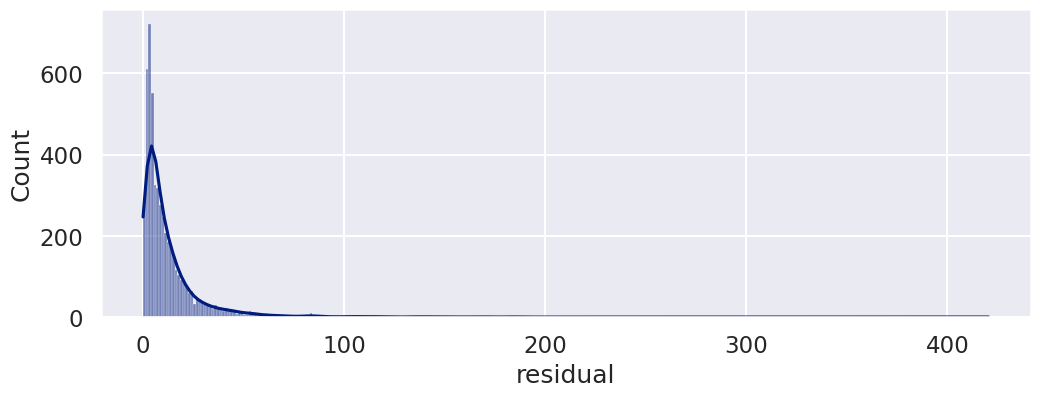

In [26]:
plt.figure(figsize=(12, 4))
sns.histplot(df_item['abs_residual'], kde=True)
plt.xlabel('residual')
plt.show()

# Modifications

In [ ]:

# error_analysis_items_list=error_analysis_file[(error_analysis_file["release_day"].isin([29,30,31]))&\
#                                               (error_analysis_file["unique_in_33"]==1)]["item_id"].unique()

#categories in shop 55 
cat_55_shop=[39,25,31,76]
submission.loc[((submission["item_category_id"].isin(cat_55_shop))&\
           (submission["shop_id"]!=55)),"item_cnt_month"]=0



###############one direction with id 5320 and name ONE DIRECTION Made In The A.M.	 was definitely a hit
submission.loc[((submission["item_id"]==5320)&(submission["shop_id"]!=55)),"item_cnt_month"]=\
submission.loc[((submission["item_id"]==5320)&(submission["shop_id"]!=55)),"item_cnt_month"]*3


submission.loc[((submission["item_id"]==18743)&(submission["shop_id"]!=55)),"item_cnt_month"]=\
submission.loc[((submission["item_id"]==18743)&(submission["shop_id"]!=55)),"item_cnt_month"]*2




#category id 34 always remain above 20 so
submission.loc[((submission["item_category_id"]==34)&\
(submission["shop_id"]==55)),"item_cnt_month"]=20

submission.loc[((submission["item_category_id"]==34)&\
(submission["shop_id"]!=55)),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==7223),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==7223),"item_cnt_month"]*1.3
# #

##5268 need for speed might be a popular game
submission.loc[(submission["item_id"]==5268),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5268),"item_cnt_month"]*3



#2323 is call of duty black hawks down is very popular and for PS4 it was a super hit as seen from google ratings and wikipedia 
submission.loc[(submission["item_id"]==2323),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2323),"item_cnt_month"]*3

# 2327 s call of duty black hawks down is very popular and for PS4 it was a super hit as seen from google ratings and wikipedia
submission.loc[(submission["item_id"]==2327),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2327),"item_cnt_month"]*3


#3408 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3408),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3408),"item_cnt_month"]*3

# 3405 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3405),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3405),"item_cnt_month"]*3

# 3407 Fallout 4 eleased in 2015 is very popular
submission.loc[(submission["item_id"]==3407),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3407),"item_cnt_month"]*3

#6729 and 6732,6731  are starwars battlefront variants and they all are extremely popular
submission.loc[(submission["item_id"]==6729),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6729),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==6731),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6731),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==6732),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6732),"item_cnt_month"]*1.5

#7782 wasteland is somewhat popular but not so 
submission.loc[(submission["item_id"]==7782),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==7782),"item_cnt_month"]*1.5
#PC game football
submission.loc[(submission["item_id"]==3538),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3538),"item_cnt_month"]*1.5
#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]*1.5

#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==2326),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2326),"item_cnt_month"]*1.5

#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==2328),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2328),"item_cnt_month"]*2
#rise of tomb rider xbox1
submission.loc[(submission["item_id"]==1577),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1577),"item_cnt_month"]*1.5
# #rise of tomb rider xbox1
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]*1.5
# #rise of tomb rider xbox1
submission.loc[(submission["item_id"]==4060),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==4060),"item_cnt_month"]*2








# .comic high rating
submission.loc[(submission["item_id"]==13310),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13310),"item_cnt_month"]*3

# submission.loc[(submission["item_id"]==13338),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13338),"item_cnt_month"]*1.5

# submission.loc[(submission["item_id"]==13309),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13309),"item_cnt_month"]*1.5

#3571  angels and ghost was quite popular
submission.loc[(submission["item_id"]==3571),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3571),"item_cnt_month"]*2

#3984 JARRE JEAN MICHEL  Electronika 1  The Time Machine released on october16 15 will also be sold in november
submission.loc[(submission["item_id"]==3984),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3984),"item_cnt_month"]*2

#Selena gomez revival
submission.loc[(submission["item_id"]==3604),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3604),"item_cnt_month"]*1.5

#botelli 
submission.loc[(submission["item_id"]==1732),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1732),"item_cnt_month"]*1.5

#botelli 
submission.loc[(submission["item_id"]==1246),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==1246),"item_cnt_month"]*1.5


# 6335 STEWART ROD  Another Country
submission.loc[(submission["item_id"]==6335),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6335),"item_cnt_month"]*1.5

# 10203 quite popular when starts
submission.loc[(submission["item_id"]==10203),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10203),"item_cnt_month"]*1.5

# 6152 tom raider is a famous game
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6152),"item_cnt_month"]*1.5

# 6153 tom raider is a famous game
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6153),"item_cnt_month"]*3

# 6742 statecraft is a famous game
submission.loc[(submission["item_id"]==6742),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6742),"item_cnt_month"]*3



#13745 BLACK WITCHER IS PLAYED AND IS FAMOUS
submission.loc[(submission["item_id"]==13745),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13745),"item_cnt_month"]*3
               

# #5269 \nfs will be a a hot selll
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269),"item_cnt_month"]*3

# # #ЛЕВША famous movie
# submission.loc[(submission["item_id"]==13804),"item_cnt_month"]=\
# submission.loc[(submission["item_id"]==13804),"item_cnt_month"]*2

# #mission impossible  famous movie
submission.loc[(submission["item_id"]==14647),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==14647),"item_cnt_month"]*2






special_shops=[25,31,42]

# #mission impossible  famous movie
submission.loc[(submission["item_id"]==14648),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==14648),"item_cnt_month"]*3
submission.loc[(submission["item_id"]==14648)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=20

special_shops=[25,31,42]

submission.loc[(submission["item_id"]==2427)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=8


submission.loc[(submission["item_id"]==5268)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5268)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==5269)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==5269)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==13745)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==13745)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3408)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3408)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3405)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3405)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==3407)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3407)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==2327)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==2327)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2

submission.loc[(submission["item_id"]==6742)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==6742)&(submission["shop_id"].isin(special_shops)),"item_cnt_month"]*2



special_shops_new=[25,31,42]
submission.loc[(submission["item_id"]==10447)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10447)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==19655)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==19655)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5

submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin(special_shops_new)),"item_cnt_month"]*1.5









In [ ]:
submission.loc[(submission["item_id"].isin([5268]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([204075]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([204077]))&(submission["shop_id"]==39),"item_cnt_month"]=18
submission.loc[(submission["item_id"].isin([6742]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([2327]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([2323]))&(submission["shop_id"]==39),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([13247]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([13247]))&(submission["shop_id"]==25),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([14959])),"item_cnt_month"]=\
submission.loc[(submission["item_id"].isin([14959])),"item_cnt_month"]*2
submission.loc[(submission["item_id"].isin([13303])),"item_cnt_month"]=\
submission.loc[(submission["item_id"].isin([13303])),"item_cnt_month"]*2



submission.loc[(submission["item_id"].isin([21811]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([17270]))&(submission["shop_id"]==39),"item_cnt_month"]=20
submission.loc[(submission["item_id"].isin([6732]))&(submission["shop_id"]==39),"item_cnt_month"]=20

submission.loc[(submission["item_id"].isin([2326]))&(submission["shop_id"]==39),"item_cnt_month"]=4
submission.loc[(submission["item_id"].isin([13246]))&(submission["shop_id"]==39),"item_cnt_month"]=5
submission.loc[(submission["item_id"].isin([1583]))&(submission["shop_id"]==39),"item_cnt_month"]=5


#good rating 
submission.loc[(submission["item_id"].isin([10449]))&(submission["shop_id"]==39),"item_cnt_month"]=16
submission.loc[(submission["item_id"].isin([16629]))&(submission["shop_id"]==39),"item_cnt_month"]=16
submission.loc[(submission["item_id"].isin([13805]))&(submission["shop_id"]==39),"item_cnt_month"]=16

In [ ]:
#
shops=[31,12,42,25]
submission.loc[(submission["item_id"]==20486),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20486),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20486)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==20401),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20401),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20401)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==20400),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==20400),"item_cnt_month"]*1.5
submission.loc[(submission["item_id"]==20400)&(submission["shop_id"]==42),"item_cnt_month"]=10

submission.loc[(submission["item_id"]==4156)&(submission["shop_id"].isin([22,24,56,57,25,31])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==4156)&(submission["shop_id"].isin([22,24,56,57,25,31])),"item_cnt_month"]*3

submission.loc[(submission["item_id"]==20949)&(~submission["shop_id"].isin([55,2])),"item_cnt_month"]=20


submission.loc[(submission["item_id"]==11373)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11373)&(submission["shop_id"]!=12),"item_cnt_month"]=0


submission.loc[(submission["item_id"]==11370)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11370)&(submission["shop_id"]!=12),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==11369)&(submission["shop_id"]==12),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==11369)&(submission["shop_id"]!=12),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==13342)&(submission["shop_id"]==55),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==13342)&(submission["shop_id"]!=55),"item_cnt_month"]=0

submission.loc[(submission["item_id"]==492)&(submission["shop_id"]==55),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==17717)&(submission["shop_id"]==31),"item_cnt_month"]=20
submission.loc[(submission["item_id"]==17717)&(submission["shop_id"]==42),"item_cnt_month"]=20



submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==31),"item_cnt_month"]=5
submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==42),"item_cnt_month"]=8
submission.loc[(submission["item_id"]==7224)&(submission["shop_id"]==25),"item_cnt_month"]=8


submission.loc[(submission["item_id"]==4894)&(submission["shop_id"].isin([25,31,42])),"item_cnt_month"]=2
submission.loc[(submission["item_id"]==19657)&(submission["shop_id"].isin([57])),"item_cnt_month"]=3
submission.loc[(submission["item_id"]==10449)&(submission["shop_id"].isin([57])),"item_cnt_month"]=3


submission.loc[(submission["item_id"]==2431)&(submission["shop_id"].isin([26,25,42])),"item_cnt_month"]=12

shops_new=[42,25,31]
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]*3
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=\
submission.loc[(submission["item_id"]==3838)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"].clip(0,8)

shops_new=[42,25,31,12,28]
submission.loc[(submission["item_id"]==7728)&(submission["shop_id"].isin([shops_new])),"item_cnt_month"]=8



In [ ]:
submission['item_cnt_month']=submission['item_cnt_month'].clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('../data/predictions/t.csv', index=False)